This particular challenge is perfect for data scientists looking to get started with Natural Language Processing. You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# Data overview

* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [221]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import nltk
from sklearn.experimental import enable_iterative_imputer
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

import os
cwd = os.getcwd()
cwd = cwd.replace('\\','/')

train = pd.read_csv(cwd + "/nlp/train.csv")
test = pd.read_csv(cwd + "/nlp/test.csv")
sub = pd.read_csv(cwd + "/nlp/sample_submission.csv")


# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum()))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum()))
# remove duplicates from train
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))
    
df_data = pd.concat([train_d, test])

Train Shape: (7613, 5)
Missing Data: 2594
Duplicates: 0

Test Shape: (3263, 4)
Missing Data: 1131
Duplicates: 0

No duplicates


In [222]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [223]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [224]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Exploratory Data Analysis (EDA)

In [225]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [226]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [227]:
train['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [228]:
train['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [229]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

or

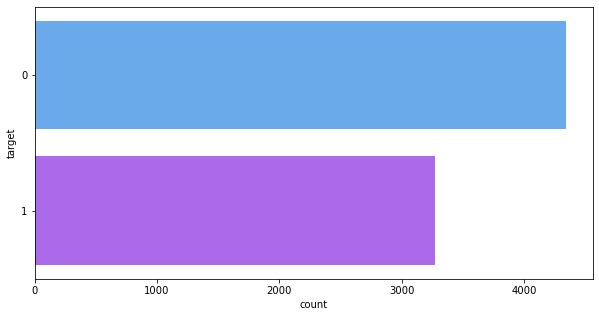

In [230]:
plt.figure(figsize=(10,5))
sns.countplot(y=train['target'], palette='cool', orient='h')
plt.show()

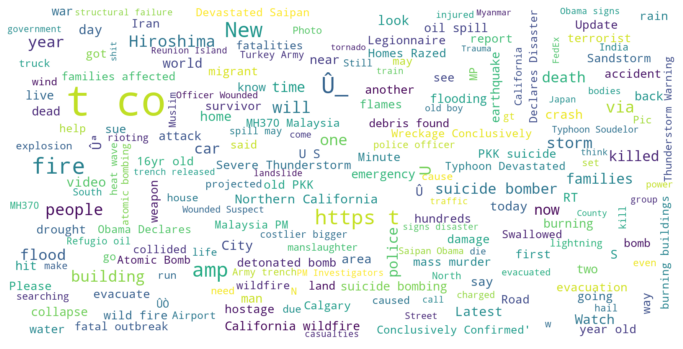

In [231]:
#Disaster Tweets wordcloud 
disaster_tweets = train[train.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Feature Engineering (FE)

## Feature generation

In [232]:
import string
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

# lenth of № of characters
df_data['body_len'] = df_data['text'].apply(lambda x: len(x) - x.count(" ")) # x.count(" ") - number of spaces; len(x) - each character

# % pucntuation
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation]) # 1 if comma, etc
    return round(count/(len(text) - text.count(" ")), 3)*100
df_data['punct%'] = df_data['text'].apply(lambda x: count_punct(x))

# word_count
df_data['word_count'] = df_data['text'].apply(lambda x: len(str(x).split())) # split - divides on words
# unique_word_count
df_data['unique_word_count'] = df_data['text'].apply(lambda x: len(set(str(x).split()))) # unique - use set
# stop_word_count
df_data['stop_word_count'] = df_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))
# url_count
df_data['url_count'] = df_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
# mean_word_length
df_data['mean_word_length'] = df_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# char_count
df_data['char_count'] = df_data['text'].apply(lambda x: len(str(x)))
df_data.head(2)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,57,1.8,13,13,6,0,4.384615,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,32,3.1,7,7,0,0,4.571429,38


In [233]:
# METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
#                 'char_count']
# DISASTER_TWEETS = train['target'] == 1

# fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

# for i, feature in enumerate(METAFEATURES):
#     sns.distplot(train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
#     sns.distplot(train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

#     sns.distplot(train[feature], label='Training', ax=axes[i][1])
#     sns.distplot(test[feature], label='Test', ax=axes[i][1])
    
#     for j in range(2):
#         axes[i][j].set_xlabel('')
#         axes[i][j].tick_params(axis='x', labelsize=12)
#         axes[i][j].tick_params(axis='y', labelsize=12)
#         axes[i][j].legend()
    
#     axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
#     axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

# plt.show()

## Punctuation removing, tokenization, stop-words removing, lemmatization

In [234]:
df_data.head(1)

,id,keyword,location,text,target,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,57,1.8,13,13,6,0,4.384615,69


In [235]:
import string
import re

# Punctuation
def remove_punct(text):
    text_punct = "".join([char for char in text if char not in string.punctuation])
    return text_punct

# tokenization
def tokenize(text):
    tokens = re.split(
        '\W+', text
    )  # W+ mean that either a word character (A-Za-9) or a dash(-) can go there
    return tokens

# stopwords removing
def remove_stodwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]
    return text

# string.punctuation
df_data['text_punct'] = df_data['text'].apply(lambda x: remove_punct(x))
df_data['text_tokens'] = df_data['text_punct'].apply(lambda x: tokenize(x.lower()))
df_data['text_stopwords'] = df_data['text_tokens'].apply(lambda x: remove_stodwords(x))

#Lemmatization is more complex but precise. Choose it.
wn = nltk.WordNetLemmatizer()
nltk.download('omw-1.4')
nltk.download('wordnet')
def lemmatizing(text_stopwords):
    text = [wn.lemmatize(word) for word in text_stopwords]
    return text

df_data['text_lemmatizing'] = df_data['text_stopwords'].apply(lambda x:lemmatizing(x))
df_data.head(2)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,keyword,location,text,target,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,text_punct,text_tokens,text_stopwords,text_lemmatizing
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,57,1.8,13,13,6,0,4.384615,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,32,3.1,7,7,0,0,4.571429,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"


## Join tokenized text

In [236]:
df_data.drop('text_punct', axis=1, inplace=True)
df_data.drop('text_tokens', axis=1, inplace=True)
df_data.drop('text_stopwords', axis=1, inplace=True)
df_data.drop('text', axis=1, inplace=True)
df_data.drop('keyword', axis=1, inplace=True)
df_data.drop('location', axis=1, inplace=True)
df_data.drop('id', axis=1, inplace=True)

# join clean tokenized text
def join_fun(text):
    string=" "
    ans=string.join(text)
    return ans

df_data['final_text']=df_data['text_lemmatizing'].apply(lambda x:join_fun(x))
df_data.drop('text_lemmatizing', axis=1, inplace=True)
df_data.head(2)

,target,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,final_text
0,1.0,57,1.8,13,13,6,0,4.384615,69,deed reason earthquake may allah forgive u
1,1.0,32,3.1,7,7,0,0,4.571429,38,forest fire near la ronge sask canada


## TD-IDF

In [237]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidfvec=TfidfVectorizer()

# vec_train=tfidfvec.fit_transform(df_data["final_text"])
# tdidf = pd.DataFrame(vec_train.toarray())
# df_data.drop('final_text', axis=1, inplace=True)

# from sklearn.preprocessing import LabelEncoder
# qualitative = [col for col in df_data if df_data[col].dtype == 'object']
# for feature in qualitative:
#     df_data[feature] = LabelEncoder().fit_transform(df_data[feature])
    
# df_data = reduce_mem_usage(df_data)

# df_data = df_data.reset_index()
# df_data = pd.concat([df_data, tdidf], axis=1)

# print(df_data.shape)

In [244]:
df_data.head(2)

,target,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,final_text
0,1.0,57,1.8,13,13,6,0,4.384615,69,deed reason earthquake may allah forgive u
1,1.0,32,3.1,7,7,0,0,4.571429,38,forest fire near la ronge sask canada


## BertTokenizier

In [253]:
df_train = df_data[df_data.target.isnull() == False]
df_test = df_data[df_data.target.isnull() == True]
df_test = df_test.drop(['target'],axis=1)

df_train.drop('body_len', axis=1, inplace=True)
df_train.drop('punct%', axis=1, inplace=True)
df_train.drop('word_count', axis=1, inplace=True)
df_train.drop('unique_word_count', axis=1, inplace=True)
df_train.drop('stop_word_count', axis=1, inplace=True)
df_train.drop('url_count', axis=1, inplace=True)
df_train.drop('mean_word_length', axis=1, inplace=True)
df_train.drop('char_count', axis=1, inplace=True)
df_train.tail(2)

,target,final_text
7611,1.0,police investigating ebike collided car little...
7612,1.0,latest home razed northern california wildfire...


In [255]:
from transformers import BertTokenizer, TFBertModel, TFAutoModel,AutoTokenizer
model_name ='joeddav/xlm-roberta-large-xnli'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def encode_sentence(s):
    tokens=[]
    tokens.append('[CLS]')
    tokens+=list(tokenizer.tokenize(s))
#    print(tokens)
    return tokenizer.convert_tokens_to_ids(tokens)
main_data=df_train['final_text']
main_data=pd.DataFrame(main_data)

tokenized=[]
for i in range(len(main_data)):
    tokenized.append(encode_sentence(main_data['final_text'][i]))
main_data['tokenized']=tokenized
main_data['target']=df_train['target']
main_data.tail(3)

,final_text,tokenized,target
7610,m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj,"[3, 347, 2947, 617, 3413, 7709, 486, 238, 758,...",1.0
7611,police investigating ebike collided car little...,"[3, 35206, 32603, 1916, 28, 60142, 61770, 4814...",1.0
7612,latest home razed northern california wildfire...,"[3, 42850, 5368, 1954, 297, 144477, 9022, 7294...",1.0


In [256]:
# see the documentations
mask=[]
for i in range(len(main_data)):
    padded_seq=tokenizer(main_data['final_text'][i],padding=True,add_special_tokens =True)
    mask.append(padded_seq)

main_data['masked']=mask
main_data.head()

,final_text,tokenized,target,masked
0,deed reason earthquake may allah forgive u,"[3, 8, 297, 31635, 109270, 13722, 350, 1543, 6...",1.0,"[input_ids, attention_mask]"
1,forest fire near la ronge sask canada,"[3, 100, 525, 11476, 43573, 21, 107629, 13, 57...",1.0,"[input_ids, attention_mask]"
2,resident asked shelter place notified officer ...,"[3, 45606, 18, 37170, 2412, 1277, 56, 3687, 95...",1.0,"[input_ids, attention_mask]"
3,13000 people receive wildfire evacuation order...,"[3, 106, 36605, 3395, 53299, 56409, 73702, 166...",1.0,"[input_ids, attention_mask]"
4,got sent photo ruby alaska smoke wildfire pour...,"[3, 4163, 9325, 16186, 21922, 53, 10, 68465, 2...",1.0,"[input_ids, attention_mask]"


In [257]:
max_len=32
def build_model():
    bert_encoder = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    embedding = bert_encoder([input_word_ids, input_mask])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [258]:
def input_convert(data):
    inputs={
        'input_word_ids':[],
        'input_mask':[]
    }
    for each in data:
        inputs['input_word_ids'].append(each['input_ids'])
        inputs['input_mask'].append(each['attention_mask'])
        
    
    inputs['input_word_ids']= tf.ragged.constant( inputs['input_word_ids']).to_tensor()
    inputs['input_mask']= tf.ragged.constant( inputs['input_mask']).to_tensor()
    return inputs

In [259]:
data_for_predictions=main_data[len(train):]
data_for_fitting=main_data[:len(train)]
data_for_fitting

,final_text,tokenized,target,masked
0,deed reason earthquake may allah forgive u,"[3, 8, 297, 31635, 109270, 13722, 350, 1543, 6...",1.0,"[input_ids, attention_mask]"
1,forest fire near la ronge sask canada,"[3, 100, 525, 11476, 43573, 21, 107629, 13, 57...",1.0,"[input_ids, attention_mask]"
2,resident asked shelter place notified officer ...,"[3, 45606, 18, 37170, 2412, 1277, 56, 3687, 95...",1.0,"[input_ids, attention_mask]"
3,13000 people receive wildfire evacuation order...,"[3, 106, 36605, 3395, 53299, 56409, 73702, 166...",1.0,"[input_ids, attention_mask]"
4,got sent photo ruby alaska smoke wildfire pour...,"[3, 4163, 9325, 16186, 21922, 53, 10, 68465, 2...",1.0,"[input_ids, attention_mask]"
...,...,...,...,...
7608,two giant crane holding bridge collapse nearby...,"[3, 6626, 6051, 18, 501, 60791, 104064, 6, 807...",1.0,"[input_ids, attention_mask]"
7609,ariaahrary thetawniest control wild fire calif...,"[3, 6, 6232, 11, 11894, 1294, 70, 102, 63205, ...",1.0,"[input_ids, attention_mask]"
7610,m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj,"[3, 347, 2947, 617, 3413, 7709, 486, 238, 758,...",1.0,"[input_ids, attention_mask]"
7611,police investigating ebike collided car little...,"[3, 35206, 32603, 1916, 28, 60142, 61770, 4814...",1.0,"[input_ids, attention_mask]"


In [260]:
import tensorflow as tf
train_input=input_convert(data_for_fitting['masked'].values)
for key in train_input.keys():
    train_input[key] = train_input[key][:,:max_len]

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

model=build_model()
model.summary()

In [ ]:
# print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

### Train

In [ ]:
# model.fit(train_input,main_data['target'].values,epochs=5,verbose=1,batch_size=128,validation_split=0.1,callbacks=[early_stop])

In [ ]:
# test_input=input_convert(data_for_predictions['masked'].values)
# for key in train_input.keys():
#     test_input[key] = test_input[key][:,:max_len]

# predictions=[np.argmax(i) for i in model.predict(test_input)]

In [ ]:
# sub['target']=predictions
# sub.to_csv("E:/downloads/sample_submission.csv",index=False)

# Modeling

In [ ]:
df_train = df_data[df_data.target.isnull() == False]
df_test = df_data[df_data.target.isnull() == True]
df_test = df_test.drop(['target'],axis=1)
X = df_train.drop('target', axis=1)
y = df_train['target']

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(task_type="GPU",devices='0:1')

model.fit(X,y,plot=True)

In [ ]:
y_preds = model.predict(df_test)
model.score(X,y)

## Pycaret

In [ ]:
from pycaret.classification import *

s = setup(data = df_train,
          target = 'target',
          train_size = 0.99,
          fold_strategy = 'stratifiedkfold',
          fold = 2,
          fold_shuffle = True)

In [ ]:
best_model = compare_models(exclude='knn')

In [ ]:
rf = create_model('rf')

In [ ]:
plot_model(tuned_rf, plot='feature')

In [ ]:
y

## CV

In [ ]:
from catboost import CatBoostClassifier
import statistics

#scores_on_split = []
#for N_SPLITS in range(20,40):

N_SPLITS = 5 # 200 is the best score on LB
N_ESTIMATORS = 1000 
RANDOM_STATE = 42 
params = {
       'n_estimators' : N_ESTIMATORS,
        'n_jobs' : -1,
         'random_state' : RANDOM_STATE
}

    #train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

scores_2 = []
scores_3 = []

X = train

y_probs_2 = []
y_probs_3 = []
print(N_SPLITS)
folds = StratifiedKFold(n_splits = N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(folds.split(X, y)):  

    print("fold : ", fold + 1, end = ' ')

    X_train = X.iloc[train_id]
    y_train = y.iloc[train_id]
    X_valid = X.iloc[test_id]
    y_valid = y.iloc[test_id]

    # model_2
    #Best: depth-10, learning_rate-0.1
    #model_2 =  ExtraTreesClassifier(**params)
    #model_2 =  RandomForestClassifier(**params)
    #model_2 =  CatBoostClassifier(verbose=False, depth=10, learning_rate=0.1)
    model_2 =  CatBoostClassifier(verbose=False)
    #model_2 = LogisticRegression(C = 0.012742749857031334)

    model_2.fit(X_train, y_train)
    # validation
    valid_pred_2 = model_2.predict(X_valid)
    valid_score_2 = accuracy_score(y_valid, valid_pred_2)
    #print( "model_2 :: Accuracy_score: ", valid_score_2, end = ' ')
    print( "Validation score: ", valid_score_2, end = ' ')
    scores_2.append(valid_score_2)

    # test
    y_pred_2 = model_2.predict(test)
    y_probs_2.append(model_2.predict_proba(test))
    print("")
    #scores_on_split.append(statistics.mean(scores_2))


#scores_on_split

# Submission

In [ ]:
sub = pd.read_csv("C:/Users/misha/Desktop/sample_project_1/NLP/sample_submission.csv")

In [ ]:
sub.head()

In [ ]:
y_preds.astype(int)

In [ ]:
# y_prob_3 = sum(y_probs_2) / len(y_probs_2)
# y_prob_3

# preds = []
# for i in y_prob_3:
#     if i[0] > i[1]:
#         preds.append(0)
#     else:
#         preds.append(1)

y_preds = y_preds.astype(int)        
def save_submission(y_pred):  
    sub["target"] = y_pred
    assert 2 == sub.shape[1]   
    sub.to_csv("E:/downloads/sample_submission.csv", index=False)
    return sub
save_submission(y_preds).head(3)